In [4]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout,GRU
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from tensorflow.keras import optimizers, Model
import matplotlib.pyplot as plt
import math

# Load Data

In [5]:
import os
CURR_FOLDER_PATH = os.getcwd()
BASE_PATH = os.path.dirname(os.path.dirname(CURR_FOLDER_PATH))
DATA_PATH = os.path.join(BASE_PATH, 'Lulus/data')

In [10]:
df = pd.read_excel(DATA_PATH + '/Hargacabaimerahharian.xlsx')

In [11]:
df

,Tanggal,Harga Cabai Merah
0,01/ 01/ 2018,31500
1,02/ 01/ 2018,31500
2,03/ 01/ 2018,31500
3,04/ 01/ 2018,32450
4,05/ 01/ 2018,32450
...,...,...
1560,25/ 12/ 2023,62050
1561,26/ 12/ 2023,62050
1562,27/ 12/ 2023,62050
1563,28/ 12/ 2023,59850


# Statistical Analytics

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Tanggal            1565 non-null   object
 1   Harga Cabai Merah  1565 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 24.6+ KB


In [13]:
df.shape

(1565, 2)


Statistik Deskriptif Harga:
count     1565.000000
mean     34173.386581
std      14036.722459
min      15300.000000
25%      24200.000000
50%      31800.000000
75%      39200.000000
max      95250.000000
Name: Harga Cabai Merah, dtype: float64


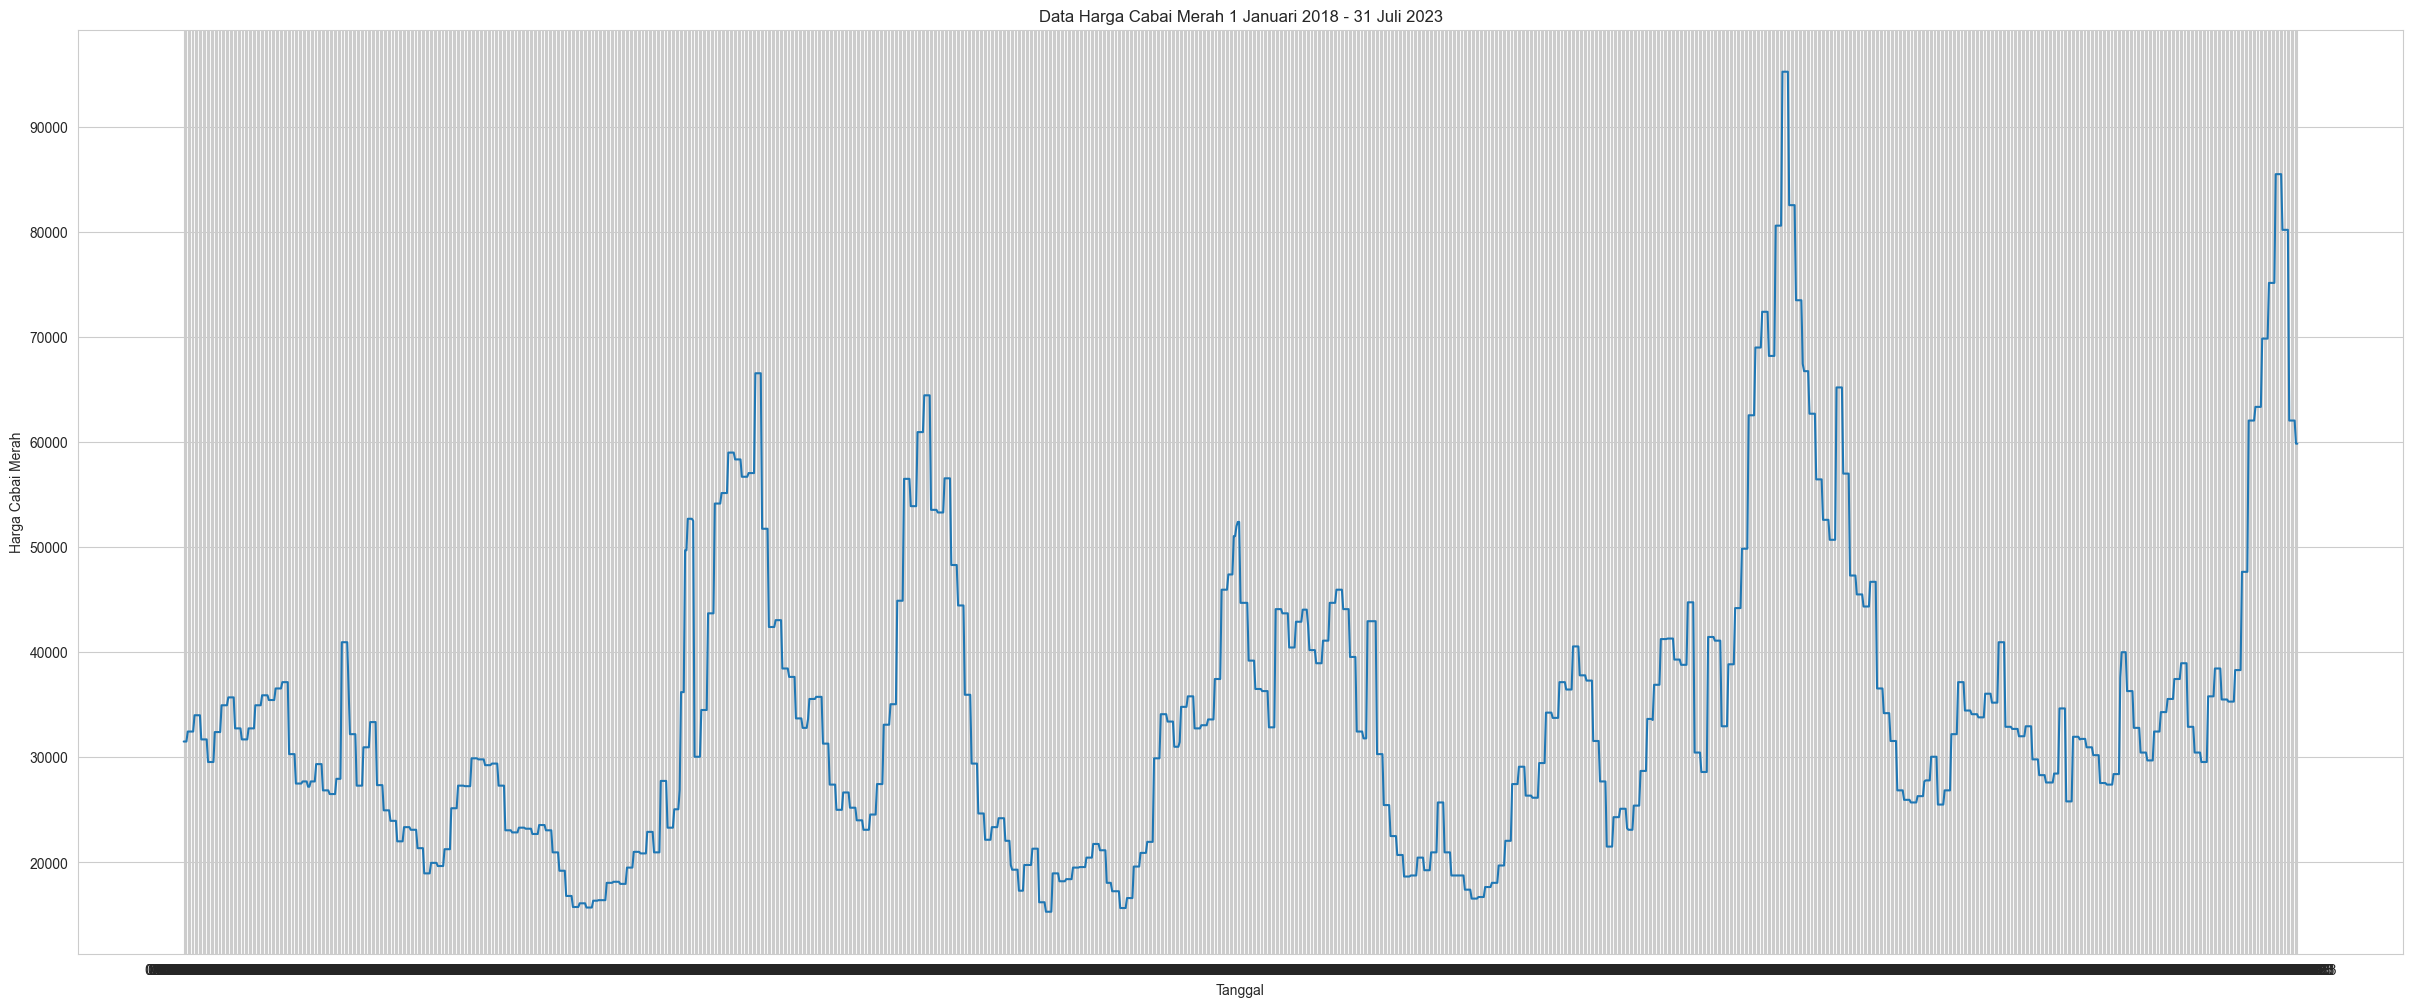

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
harga_stats = df['Harga Cabai Merah'].describe()
print("\nStatistik Deskriptif Harga:")
print(harga_stats)
plt.figure(figsize=(30, 12))
plt.plot(df['Tanggal'], df['Harga Cabai Merah'])
plt.title('Data Harga Cabai Merah 1 Januari 2018 - 31 Juli 2023')
plt.xlabel('Tanggal')
plt.ylabel('Harga Cabai Merah')
plt.show()

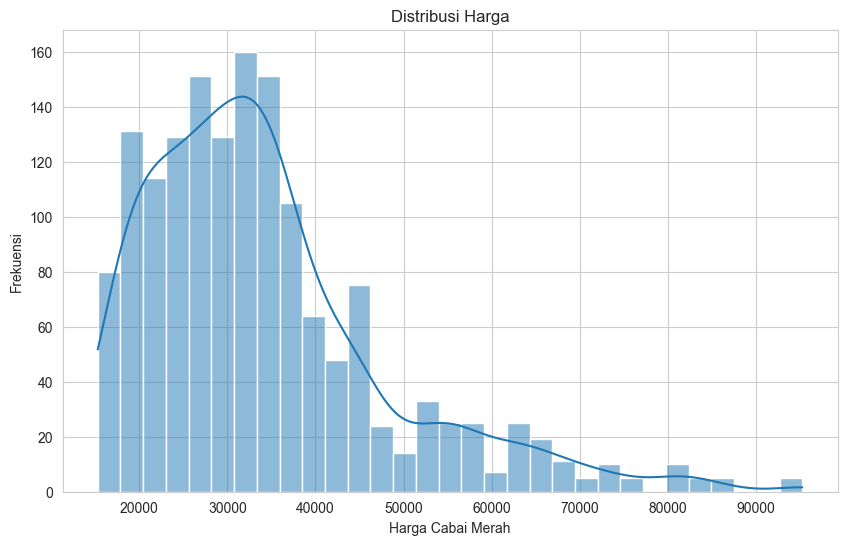

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Harga Cabai Merah'], kde=True)
plt.title('Distribusi Harga')
plt.xlabel('Harga Cabai Merah')
plt.ylabel('Frekuensi')
plt.show()

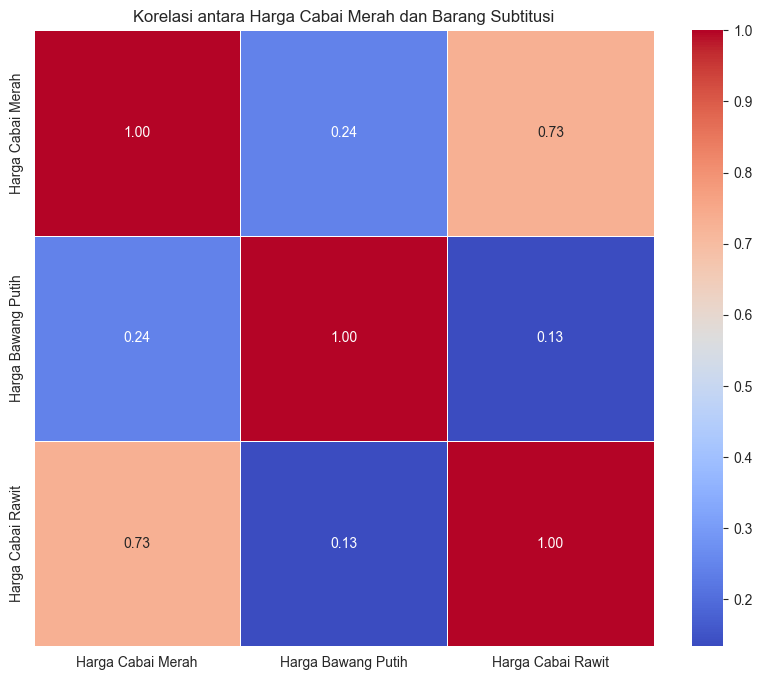

In [148]:
corr_with_target = df[['Harga Cabai Merah','Harga Bawang Putih','Harga Cabai Rawit']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Korelasi antara Harga Cabai Merah dan Barang Subtitusi')
plt.show()

In [24]:
df.describe()

,Harga Cabai Merah
count,1565.000000
mean,34173.386581
std,14036.722459
min,15300.000000
25%,24200.000000
50%,31800.000000
75%,39200.000000
max,95250.000000


# Preprocessing Data


In [25]:
df['Harga Cabai Merah'] = df['Harga Cabai Merah'].astype('float64')

In [26]:
df.isnull().sum()

Tanggal              0
Harga Cabai Merah    0
dtype: int64

In [27]:
df = df.fillna(df.mean())

C:\Users\ihsan\AppData\Local\Temp\ipykernel_24200\114435927.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


In [28]:
scaler_rr = MinMaxScaler(feature_range=(0, 1))
scaler_harga = MinMaxScaler(feature_range=(0, 1))
df['Harga Cabai Merah_Scaled'] = scaler_harga.fit_transform(df[['Harga Cabai Merah']])

In [29]:
df

,Tanggal,Harga Cabai Merah,Harga Cabai Merah_Scaled
0,01/ 01/ 2018,31500.0,0.202627
1,02/ 01/ 2018,31500.0,0.202627
2,03/ 01/ 2018,31500.0,0.202627
3,04/ 01/ 2018,32450.0,0.214509
4,05/ 01/ 2018,32450.0,0.214509
...,...,...,...
1560,25/ 12/ 2023,62050.0,0.584740
1561,26/ 12/ 2023,62050.0,0.584740
1562,27/ 12/ 2023,62050.0,0.584740
1563,28/ 12/ 2023,59850.0,0.557223


# Split Data

In [31]:
selected_columns = ['Harga Cabai Merah_Scaled']
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)][selected_columns].values
        dataX.append(a)
        dataY.append(dataset[i + look_back:i + look_back + 1]['Harga Cabai Merah_Scaled'].values)
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], len(selected_columns)))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], len(selected_columns)))

# Pembuatan Model

In [33]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1), activation='relu'))
model.add(LSTM(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, epochs=60, batch_size=64, verbose=2)


Epoch 1/60
20/20 - 2s - loss: 0.0734 - 2s/epoch - 76ms/step
Epoch 2/60
20/20 - 0s - loss: 0.0529 - 34ms/epoch - 2ms/step
Epoch 3/60
20/20 - 0s - loss: 0.0331 - 34ms/epoch - 2ms/step
Epoch 4/60
20/20 - 0s - loss: 0.0222 - 32ms/epoch - 2ms/step
Epoch 5/60
20/20 - 0s - loss: 0.0192 - 34ms/epoch - 2ms/step
Epoch 6/60
20/20 - 0s - loss: 0.0147 - 33ms/epoch - 2ms/step
Epoch 7/60
20/20 - 0s - loss: 0.0107 - 36ms/epoch - 2ms/step
Epoch 8/60
20/20 - 0s - loss: 0.0064 - 32ms/epoch - 2ms/step
Epoch 9/60
20/20 - 0s - loss: 0.0033 - 33ms/epoch - 2ms/step
Epoch 10/60
20/20 - 0s - loss: 0.0019 - 34ms/epoch - 2ms/step
Epoch 11/60
20/20 - 0s - loss: 0.0016 - 33ms/epoch - 2ms/step
Epoch 12/60
20/20 - 0s - loss: 0.0015 - 34ms/epoch - 2ms/step
Epoch 13/60
20/20 - 0s - loss: 0.0014 - 35ms/epoch - 2ms/step
Epoch 14/60
20/20 - 0s - loss: 0.0014 - 40ms/epoch - 2ms/step
Epoch 15/60
20/20 - 0s - loss: 0.0014 - 51ms/epoch - 3ms/step
Epoch 16/60
20/20 - 0s - loss: 0.0013 - 46ms/epoch - 2ms/step
Epoch 17/60
20/20 

In [34]:
predictions = model.predict(testX)
predictions = scaler_harga.inverse_transform(predictions)
testY = scaler_harga.inverse_transform(testY)

10/10 [==============================] - 0s 997us/step


In [35]:
trainY = scaler_harga.inverse_transform(trainY)

In [36]:
df_test = pd.DataFrame({'Actual': np.squeeze(testY), 'Predicted': np.squeeze(predictions)})
print(df_test)

      Actual     Predicted
0    36550.0  45972.742188
1    36550.0  36667.636719
2    36550.0  36667.636719
3    36550.0  36667.636719
4    36550.0  36667.636719
..       ...           ...
307  62050.0  60306.894531
308  62050.0  60306.894531
309  62050.0  60306.894531
310  59850.0  60306.894531
311  59850.0  58183.156250

[312 rows x 2 columns]


# Hasil Akhir

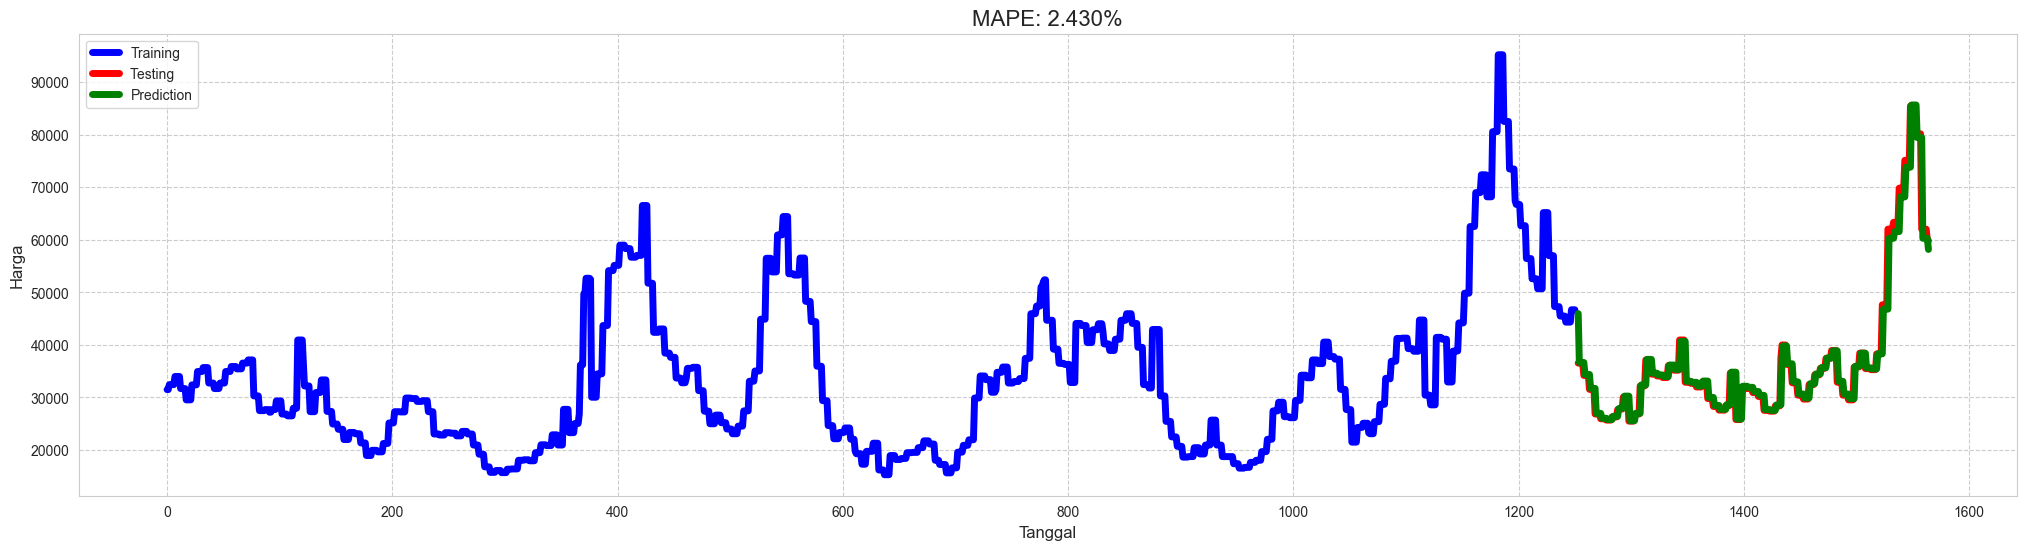

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(testY, predictions)*100
plt.figure(figsize=(25, 6))
plt.plot(df.index[:len(trainY)], trainY, label='Training', marker='', color='blue', linestyle='-', linewidth=5)
plt.plot(df.index[-len(testY):], testY, label='Testing ', marker='', color='red', linestyle='-', linewidth=5)
plt.plot(df.index[-len(predictions):], predictions, label='Prediction', marker='', color='green', linestyle='-', linewidth=5)
plt.title(f'MAPE: {mape:.3f}%', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.xticks(rotation=0)
plt.show()